# Set up

In [1]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'
#%pip install -U multiprocess
#!conda update conda -y

In [2]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata
## https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
#import multiprocessing as mp # fails on IPython environment
import multiprocess as mp # provides Pool

# Preparation 1

In [179]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.03 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 10 # values larger than 10 take considerably longer to complete
min_doc_size         =  4

## preprocessing settings
lower_chars          = True
strip_accents        = True
add_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if add_boundaries:
    hash_status = "-hashed"
else:
    hash_status = ""

## term settings
ngram_is_inclusive    = True # takes significantly more time to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
max_gap_size_factor   = 0.53 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.

## Skippy n-gram の隙間を表わす記号
gap_marker            = "…"

## spell term と sound term の連結記号
pair_marker           = " :: "

## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
sp_term_type   = sp_term_types[4]
print(f"sp_term_type: {sp_term_type}")

## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
sn_term_type = sn_term_types[3]
print(f"sn_term_type: {sn_term_type}")

sp_term_type: sp_5gram
sn_term_type: sn_4gram


In [180]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 2 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.01 # Larger values reveal deeper; 0.006 seems to be the smallest

In [181]:
## select HDP or LDA: HDP takes considerably longer than LDA,
## and is susceptible with "Not all rows sum to 1" error at pyLDAvis
## HDP
use_HDP         = True
max_n_topics    = 60
n_terms_to_show = 120

## LDA
n_topics  = max_n_topics # 精度にはあまり影響しない？
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"

## tSNE
top_perplexity_reduct_rate = 0.33
##
print(f"method_name: {method_name}")
print(f"max_n_topics for HDP: {max_n_topics}")
print(f"n_topics for LDA: {n_topics}")
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

method_name: HDP
max_n_topics for HDP: 60
n_topics for LDA: 60
top_perplexity_reduct_rate: 0.33


In [182]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = [ ]
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [183]:
## select language and file
lang_names = {  'ar' : 'Arabic',  # 0
                'de' : 'German',  # 1
                'en' : 'English', # 2
                'es' : 'Spanish', # 3
                'fr' : 'French',  # 4
                'sw' : 'Swahili'  # 5
            }
#
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw' ]
#
lang_key  = lang_keys[2]
lang_name = lang_names[lang_key]
lang_attr = ""
print(f"lang_name: {lang_name} ({lang_attr}) [lang_key: {lang_key}]")
# aliases
target_lang_dict = lang_names
target_lang_keys = lang_keys
target_lang_key  = lang_key
target_lang_attr = lang_attr
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
if len(lang_attr) > 0:
    print(f"lang_attr: {lang_attr}")
    selected_files = [ file for file in files if lang_attr in file ]
else:
    selected_files = files
selected_files
if len(selected_files) == 0:
    exit()

lang_name: English () [lang_key: en]
['data/open-dict-ipa/data1/en_US.csv.gz', 'data/open-dict-ipa/data1/en_UK.csv.gz', 'data/open-dict-ipa/data1/en_US.csv']


In [184]:
## build data from files
import re, unicodedata
import pandas as pd
check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,'bout,/ˈbaʊt/
1,'cause,/kəz/
2,'course,/ˈkɔɹs/
3,'cuse,/ˈkjuz/
4,'em,/əm/
...,...,...
125922,zysk,/ˈzaɪsk/
125923,zyskowski,/zɪˈskɔfski/
125924,zyuganov,"/ˈzjuɡɑnɑv/, /ˈzuɡɑnɑv/"
125925,zyuganov's,"/ˈzjuɡɑnɑvz/, /ˈzuɡɑnɑvz/"


In [185]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,'bout,baʊt
1,'cause,kəz
2,'course,kɔɹs
3,'cuse,kjuz
4,'em,əm
...,...,...
125922,zysk,zaɪsk
125923,zyskowski,zɪskɔfski
125924,zyuganov,zjuɡɑnɑv
125925,zyuganov's,zjuɡɑnɑvz


In [186]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,'bout,baʊt
1,2,2,'cause,kəz
2,3,3,'course,kɔɹs
3,4,4,'cuse,kjuz
4,5,5,'em,əm
...,...,...,...,...
125922,125923,125923,zysk,zaɪsk
125923,125924,125924,zyskowski,zɪskɔfski
125924,125925,125925,zyuganov,zjuɡɑnɑv
125925,125926,125926,zyuganov's,zjuɡɑnɑvz


In [187]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 3778 (0.030) rows by discarding 122149 rows


In [188]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [189]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

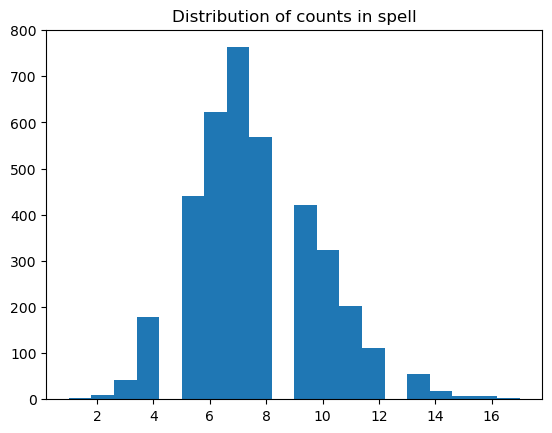

In [190]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

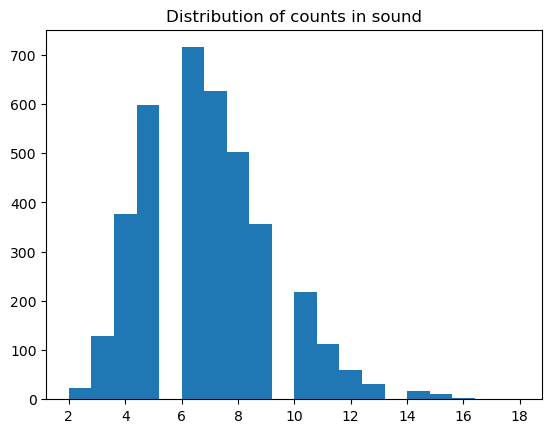

In [191]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

# build terms, part 1

In [192]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 4 chars
discarding pairs whose sn_size part has more than 10 chars
603 (0.160) pairs were removed
3175 pairs remain


In [193]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [194]:
## add 1gram
import re
w_splitter = r""
df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
98407,"[#, s, a, n, d, e, f, e, r, #]","[#, s, æ, n, d, i, f, ɝ, #]"
85362,"[#, p, e, r, s, o, n, a, e, #]","[#, p, ɝ, s, o, ʊ, n, e, ɪ, #]"
14876,"[#, b, r, u, s, s, e, a, u, #]","[#, b, ɹ, ə, s, o, ʊ, #]"
76137,"[#, m, o, w, r, e, r, #]","[#, m, ɔ, ɹ, ɝ, #]"
33449,"[#, e, a, r, m, a, r, k, #]","[#, i, ɹ, m, ɑ, ɹ, k, #]"
...,...,...
10804,"[#, b, i, l, l, m, e, y, e, r, #]","[#, b, ɪ, ɫ, m, a, ɪ, ɝ, #]"
30543,"[#, d, i, s, c, o, l, o, r, s, #]","[#, d, ɪ, s, k, ə, ɫ, ɝ, z, #]"
110715,"[#, s, w, i, n, b, u, r, n, e, ', s, #]","[#, s, w, ɪ, n, b, ɝ, n, z, #]"
103031,"[#, s, h, o, w, e, l, l, #]","[#, ʃ, ɑ, w, ɛ, ɫ, #]"


In [195]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('#', 6350),
 ('e', 2603),
 ('a', 2034),
 ('r', 1824),
 ('s', 1691),
 ('i', 1626),
 ('n', 1590),
 ('o', 1423),
 ('l', 1386),
 ('t', 1218)]

In [196]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('#', 6350),
 ('ɪ', 1602),
 ('ə', 1483),
 ('n', 1317),
 ('ɫ', 1174),
 ('t', 1109),
 ('s', 1072),
 ('ɹ', 1051),
 ('k', 954),
 ('d', 917)]

In [197]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [198]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [199]:
## generic n-gram generation function
def add_ngrams(dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippiness_symbol: str = "sk", max_distance = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    pool = mp.Pool (processes = max(os.cpu_count() - 1, 1))
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(g, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check) for g in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(g, n = n_for_ngram, sep = seg_joint, check = check) for g in unigrams ]
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [200]:
df.columns
#iter(df['sp_1gram'])

Index(['did', 'sid', 'sp_word', 'sn_word', 'sp_1gram', 'sn_1gram', 'sp_size',
       'sn_size'],
      dtype='object')

In [201]:
## sp_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#s, sa, an, nd, de, ef, fe, er, r#, #, s, a, ...
85362     [#p, pe, er, rs, so, on, na, ae, e#, #, p, e, ...
14876     [#b, br, ru, us, ss, se, ea, au, u#, #, b, r, ...
76137     [#m, mo, ow, wr, re, er, r#, #, m, o, w, r, e,...
33449     [#e, ea, ar, rm, ma, ar, rk, k#, #, e, a, r, m...
                                ...                        
10804     [#b, bi, il, ll, lm, me, ey, ye, er, r#, #, b,...
30543     [#d, di, is, sc, co, ol, lo, or, rs, s#, #, d,...
110715    [#s, sw, wi, in, nb, bu, ur, rn, ne, e', 's, s...
103031    [#s, sh, ho, ow, we, el, ll, l#, #, s, h, o, w...
34764         [#e, el, ls, si, ie, e#, #, e, l, s, i, e, #]
Name: sp_2gram, Length: 3175, dtype: object


In [202]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#sa, san, and, nde, def, efe, fer, er#, #s, s...
85362     [#pe, per, ers, rso, son, ona, nae, ae#, #p, p...
14876     [#br, bru, rus, uss, sse, sea, eau, au#, #b, b...
76137     [#mo, mow, owr, wre, rer, er#, #m, mo, ow, wr,...
33449     [#ea, ear, arm, rma, mar, ark, rk#, #e, ea, ar...
                                ...                        
10804     [#bi, bil, ill, llm, lme, mey, eye, yer, er#, ...
30543     [#di, dis, isc, sco, col, olo, lor, ors, rs#, ...
110715    [#sw, swi, win, inb, nbu, bur, urn, rne, ne', ...
103031    [#sh, sho, how, owe, wel, ell, ll#, #s, sh, ho...
34764     [#el, els, lsi, sie, ie#, #e, el, ls, si, ie, e#]
Name: sp_3gram, Length: 3175, dtype: object


In [203]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#san, sand, ande, ndef, defe, efer, fer#, #sa...
85362     [#per, pers, erso, rson, sona, onae, nae#, #pe...
14876     [#bru, brus, russ, usse, ssea, seau, eau#, #br...
76137     [#mow, mowr, owre, wrer, rer#, #mo, mow, owr, ...
33449     [#ear, earm, arma, rmar, mark, ark#, #ea, ear,...
                                ...                        
10804     [#bil, bill, illm, llme, lmey, meye, eyer, yer...
30543     [#dis, disc, isco, scol, colo, olor, lors, ors...
110715    [#swi, swin, winb, inbu, nbur, burn, urne, rne...
103031    [#sho, show, howe, owel, well, ell#, #sh, sho,...
34764     [#els, elsi, lsie, sie#, #el, els, lsi, sie, ie#]
Name: sp_4gram, Length: 3175, dtype: object


In [204]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#sand, sande, andef, ndefe, defer, efer#, #sa...
85362     [#pers, perso, erson, rsona, sonae, onae#, #pe...
14876     [#brus, bruss, russe, ussea, sseau, seau#, #br...
76137     [#mowr, mowre, owrer, wrer#, #mow, mowr, owre,...
33449     [#earm, earma, armar, rmark, mark#, #ear, earm...
                                ...                        
10804     [#bill, billm, illme, llmey, lmeye, meyer, eye...
30543     [#disc, disco, iscol, scolo, color, olors, lor...
110715    [#swin, swinb, winbu, inbur, nburn, burne, urn...
103031    [#show, showe, howel, owell, well#, #sho, show...
34764         [#elsi, elsie, lsie#, #els, elsi, lsie, sie#]
Name: sp_5gram, Length: 3175, dtype: object


In [205]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#s, #…a, #…n, #…d, sa, s…n, s…d, an, a…d, nd,...
85362     [#p, #…e, #…r, #…s, pe, p…r, p…s, er, e…s, rs,...
14876     [#b, #…r, #…u, #…s, br, b…u, b…s, ru, r…s, us,...
76137     [#m, #…o, #…w, #…r, mo, m…w, m…r, ow, o…r, wr,...
33449     [#e, #…a, #…r, #…m, ea, e…r, e…m, ar, a…m, rm,...
                                ...                        
10804     [#b, #…i, #…l, #…l, bi, b…l, b…l, il, i…l, ll,...
30543     [#d, #…i, #…s, #…c, di, d…s, d…c, is, i…c, sc,...
110715    [#s, #…w, #…i, #…n, sw, s…i, s…n, wi, w…n, in,...
103031    [#s, #…h, #…o, #…w, sh, s…o, s…w, ho, h…w, ow,...
34764     [#e, #…l, #…s, #…i, el, e…s, e…i, ls, l…i, si,...
Name: sp_sk2gram, Length: 3175, dtype: object


In [206]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#sa, #s…n, #s…d, #…an, #…a…d, #…nd, san, sa…d...
85362     [#pe, #p…r, #p…s, #…er, #…e…s, #…rs, per, pe…s...
14876     [#br, #b…u, #b…s, #…ru, #…r…s, #…us, bru, br…s...
76137     [#mo, #m…w, #m…r, #…ow, #…o…r, #…wr, mow, mo…r...
33449     [#ea, #e…r, #e…m, #…ar, #…a…m, #…rm, ear, ea…m...
                                ...                        
10804     [#bi, #b…l, #b…l, #…il, #…i…l, #…ll, bil, bi…l...
30543     [#di, #d…s, #d…c, #…is, #…i…c, #…sc, dis, di…c...
110715    [#sw, #s…i, #s…n, #…wi, #…w…n, #…in, swi, sw…n...
103031    [#sh, #s…o, #s…w, #…ho, #…h…w, #…ow, sho, sh…w...
34764     [#el, #e…s, #e…i, #…ls, #…l…i, #…si, els, el…i...
Name: sp_sk3gram, Length: 3175, dtype: object


In [207]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#san, #sa…d, #s…nd, #…and, sand, sand, san…e,...
85362     [#per, #pe…s, #p…rs, #…ers, pers, pers, per…o,...
14876     [#bru, #br…s, #b…us, #…rus, brus, brus, bru…s,...
76137     [#mow, #mo…r, #m…wr, #…owr, mowr, mowr, mow…e,...
33449     [#ear, #ea…m, #e…rm, #…arm, earm, earm, ear…a,...
                                ...                        
10804     [#bil, #bi…l, #b…ll, #…ill, bill, bill, bil…m,...
30543     [#dis, #di…c, #d…sc, #…isc, disc, disc, dis…o,...
110715    [#swi, #sw…n, #s…in, #…win, swin, swin, swi…b,...
103031    [#sho, #sh…w, #s…ow, #…how, show, show, sho…e,...
34764     [#els, #el…i, #e…si, #…lsi, elsi, elsi, els…e,...
Name: sp_sk4gram, Length: 3175, dtype: object


In [208]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#sand, sande, andef, ndefe, defer, efer#, #sa...
85362     [#pers, perso, erson, rsona, sonae, onae#, #pe...
14876     [#brus, bruss, russe, ussea, sseau, seau#, #br...
76137     [#mowr, mowre, owrer, wrer#, #mow, #mo…r, #m…w...
33449     [#earm, earma, armar, rmark, mark#, #ear, #ea…...
                                ...                        
10804     [#bill, billm, illme, llmey, lmeye, meyer, eye...
30543     [#disc, disco, iscol, scolo, color, olors, lor...
110715    [#swin, swinb, winbu, inbur, nburn, burne, urn...
103031    [#show, showe, howel, owell, well#, #sho, #sh…...
34764     [#elsi, elsie, lsie#, #els, #el…i, #e…si, #…ls...
Name: sp_sk5gram, Length: 3175, dtype: object


In [209]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram,sp_sk5gram
98407,#sandefer#,"[#s, #…a, #…n, #…d, sa, s…n, s…d, an, a…d, nd,...","[#sa, #s…n, #s…d, #…an, #…a…d, #…nd, san, sa…d...","[#san, #sa…d, #s…nd, #…and, sand, sand, san…e,...","[#sand, sande, andef, ndefe, defer, efer#, #sa..."
85362,#personae#,"[#p, #…e, #…r, #…s, pe, p…r, p…s, er, e…s, rs,...","[#pe, #p…r, #p…s, #…er, #…e…s, #…rs, per, pe…s...","[#per, #pe…s, #p…rs, #…ers, pers, pers, per…o,...","[#pers, perso, erson, rsona, sonae, onae#, #pe..."
14876,#brusseau#,"[#b, #…r, #…u, #…s, br, b…u, b…s, ru, r…s, us,...","[#br, #b…u, #b…s, #…ru, #…r…s, #…us, bru, br…s...","[#bru, #br…s, #b…us, #…rus, brus, brus, bru…s,...","[#brus, bruss, russe, ussea, sseau, seau#, #br..."
76137,#mowrer#,"[#m, #…o, #…w, #…r, mo, m…w, m…r, ow, o…r, wr,...","[#mo, #m…w, #m…r, #…ow, #…o…r, #…wr, mow, mo…r...","[#mow, #mo…r, #m…wr, #…owr, mowr, mowr, mow…e,...","[#mowr, mowre, owrer, wrer#, #mow, #mo…r, #m…w..."
33449,#earmark#,"[#e, #…a, #…r, #…m, ea, e…r, e…m, ar, a…m, rm,...","[#ea, #e…r, #e…m, #…ar, #…a…m, #…rm, ear, ea…m...","[#ear, #ea…m, #e…rm, #…arm, earm, earm, ear…a,...","[#earm, earma, armar, rmark, mark#, #ear, #ea…..."
...,...,...,...,...,...
10804,#billmeyer#,"[#b, #…i, #…l, #…l, bi, b…l, b…l, il, i…l, ll,...","[#bi, #b…l, #b…l, #…il, #…i…l, #…ll, bil, bi…l...","[#bil, #bi…l, #b…ll, #…ill, bill, bill, bil…m,...","[#bill, billm, illme, llmey, lmeye, meyer, eye..."
30543,#discolors#,"[#d, #…i, #…s, #…c, di, d…s, d…c, is, i…c, sc,...","[#di, #d…s, #d…c, #…is, #…i…c, #…sc, dis, di…c...","[#dis, #di…c, #d…sc, #…isc, disc, disc, dis…o,...","[#disc, disco, iscol, scolo, color, olors, lor..."
110715,#swinburne's#,"[#s, #…w, #…i, #…n, sw, s…i, s…n, wi, w…n, in,...","[#sw, #s…i, #s…n, #…wi, #…w…n, #…in, swi, sw…n...","[#swi, #sw…n, #s…in, #…win, swin, swin, swi…b,...","[#swin, swinb, winbu, inbur, nburn, burne, urn..."
103031,#showell#,"[#s, #…h, #…o, #…w, sh, s…o, s…w, ho, h…w, ow,...","[#sh, #s…o, #s…w, #…ho, #…h…w, #…ow, sho, sh…w...","[#sho, #sh…w, #s…ow, #…how, show, show, sho…e,...","[#show, showe, howel, owell, well#, #sho, #sh…..."


# Sound n-grams 生成

In [210]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#s, sæ, æn, nd, di, if, fɝ, ɝ#, #, s, æ, n, d...
85362     [#p, pɝ, ɝs, so, oʊ, ʊn, ne, eɪ, ɪ#, #, p, ɝ, ...
14876     [#b, bɹ, ɹə, əs, so, oʊ, ʊ#, #, b, ɹ, ə, s, o,...
76137                [#m, mɔ, ɔɹ, ɹɝ, ɝ#, #, m, ɔ, ɹ, ɝ, #]
33449     [#i, iɹ, ɹm, mɑ, ɑɹ, ɹk, k#, #, i, ɹ, m, ɑ, ɹ,...
                                ...                        
10804     [#b, bɪ, ɪɫ, ɫm, ma, aɪ, ɪɝ, ɝ#, #, b, ɪ, ɫ, m...
30543     [#d, dɪ, ɪs, sk, kə, əɫ, ɫɝ, ɝz, z#, #, d, ɪ, ...
110715    [#s, sw, wɪ, ɪn, nb, bɝ, ɝn, nz, z#, #, s, w, ...
103031        [#ʃ, ʃɑ, ɑw, wɛ, ɛɫ, ɫ#, #, ʃ, ɑ, w, ɛ, ɫ, #]
34764                [#ɛ, ɛɫ, ɫs, si, i#, #, ɛ, ɫ, s, i, #]
Name: sn_2gram, Length: 3175, dtype: object


In [211]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#sæ, sæn, ænd, ndi, dif, ifɝ, fɝ#, #s, sæ, æn...
85362     [#pɝ, pɝs, ɝso, soʊ, oʊn, ʊne, neɪ, eɪ#, #p, p...
14876     [#bɹ, bɹə, ɹəs, əso, soʊ, oʊ#, #b, bɹ, ɹə, əs,...
76137              [#mɔ, mɔɹ, ɔɹɝ, ɹɝ#, #m, mɔ, ɔɹ, ɹɝ, ɝ#]
33449     [#iɹ, iɹm, ɹmɑ, mɑɹ, ɑɹk, ɹk#, #i, iɹ, ɹm, mɑ,...
                                ...                        
10804     [#bɪ, bɪɫ, ɪɫm, ɫma, maɪ, aɪɝ, ɪɝ#, #b, bɪ, ɪɫ...
30543     [#dɪ, dɪs, ɪsk, skə, kəɫ, əɫɝ, ɫɝz, ɝz#, #d, d...
110715    [#sw, swɪ, wɪn, ɪnb, nbɝ, bɝn, ɝnz, nz#, #s, s...
103031    [#ʃɑ, ʃɑw, ɑwɛ, wɛɫ, ɛɫ#, #ʃ, ʃɑ, ɑw, wɛ, ɛɫ, ɫ#]
34764              [#ɛɫ, ɛɫs, ɫsi, si#, #ɛ, ɛɫ, ɫs, si, i#]
Name: sn_3gram, Length: 3175, dtype: object


In [212]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#sæn, sænd, ændi, ndif, difɝ, ifɝ#, #sæ, sæn,...
85362     [#pɝs, pɝso, ɝsoʊ, soʊn, oʊne, ʊneɪ, neɪ#, #pɝ...
14876     [#bɹə, bɹəs, ɹəso, əsoʊ, soʊ#, #bɹ, bɹə, ɹəs, ...
76137                [#mɔɹ, mɔɹɝ, ɔɹɝ#, #mɔ, mɔɹ, ɔɹɝ, ɹɝ#]
33449     [#iɹm, iɹmɑ, ɹmɑɹ, mɑɹk, ɑɹk#, #iɹ, iɹm, ɹmɑ, ...
                                ...                        
10804     [#bɪɫ, bɪɫm, ɪɫma, ɫmaɪ, maɪɝ, aɪɝ#, #bɪ, bɪɫ,...
30543     [#dɪs, dɪsk, ɪskə, skəɫ, kəɫɝ, əɫɝz, ɫɝz#, #dɪ...
110715    [#swɪ, swɪn, wɪnb, ɪnbɝ, nbɝn, bɝnz, ɝnz#, #sw...
103031    [#ʃɑw, ʃɑwɛ, ɑwɛɫ, wɛɫ#, #ʃɑ, ʃɑw, ɑwɛ, wɛɫ, ɛɫ#]
34764                [#ɛɫs, ɛɫsi, ɫsi#, #ɛɫ, ɛɫs, ɫsi, si#]
Name: sn_4gram, Length: 3175, dtype: object


In [213]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [214]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#s, #…æ, #…n, #…d, sæ, s…n, s…d, æn, æ…d, nd,...
85362     [#p, #…ɝ, #…s, #…o, pɝ, p…s, p…o, ɝs, ɝ…o, so,...
14876     [#b, #…ɹ, #…ə, #…s, bɹ, b…ə, b…s, ɹə, ɹ…s, əs,...
76137     [#m, #…ɔ, #…ɹ, #…ɝ, mɔ, m…ɹ, m…ɝ, ɔɹ, ɔ…ɝ, ɹɝ,...
33449     [#i, #…ɹ, #…m, #…ɑ, iɹ, i…m, i…ɑ, ɹm, ɹ…ɑ, mɑ,...
                                ...                        
10804     [#b, #…ɪ, #…ɫ, #…m, bɪ, b…ɫ, b…m, ɪɫ, ɪ…m, ɫm,...
30543     [#d, #…ɪ, #…s, #…k, dɪ, d…s, d…k, ɪs, ɪ…k, sk,...
110715    [#s, #…w, #…ɪ, #…n, sw, s…ɪ, s…n, wɪ, w…n, ɪn,...
103031    [#ʃ, #…ɑ, #…w, #…ɛ, ʃɑ, ʃ…w, ʃ…ɛ, ɑw, ɑ…ɛ, wɛ,...
34764     [#ɛ, #…ɫ, #…s, #…i, ɛɫ, ɛ…s, ɛ…i, ɫs, ɫ…i, si,...
Name: sn_sk2gram, Length: 3175, dtype: object


In [215]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#sæ, #s…n, #s…d, #…æn, #…æ…d, #…nd, sæn, sæ…d...
85362     [#pɝ, #p…s, #p…o, #…ɝs, #…ɝ…o, #…so, pɝs, pɝ…o...
14876     [#bɹ, #b…ə, #b…s, #…ɹə, #…ɹ…s, #…əs, bɹə, bɹ…s...
76137     [#mɔ, #m…ɹ, #m…ɝ, #…ɔɹ, #…ɔ…ɝ, #…ɹɝ, mɔɹ, mɔ…ɝ...
33449     [#iɹ, #i…m, #i…ɑ, #…ɹm, #…ɹ…ɑ, #…mɑ, iɹm, iɹ…ɑ...
                                ...                        
10804     [#bɪ, #b…ɫ, #b…m, #…ɪɫ, #…ɪ…m, #…ɫm, bɪɫ, bɪ…m...
30543     [#dɪ, #d…s, #d…k, #…ɪs, #…ɪ…k, #…sk, dɪs, dɪ…k...
110715    [#sw, #s…ɪ, #s…n, #…wɪ, #…w…n, #…ɪn, swɪ, sw…n...
103031    [#ʃɑ, #ʃ…w, #ʃ…ɛ, #…ɑw, #…ɑ…ɛ, #…wɛ, ʃɑw, ʃɑ…ɛ...
34764     [#ɛɫ, #ɛ…s, #ɛ…i, #…ɫs, #…ɫ…i, #…si, ɛɫs, ɛɫ…i...
Name: sn_sk3gram, Length: 3175, dtype: object


In [216]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98407     [#sæn, #sæ…d, #s…nd, #…ænd, sænd, sænd, sæn…i,...
85362     [#pɝs, #pɝ…o, #p…so, #…ɝso, pɝso, pɝso, pɝs…ʊ,...
14876     [#bɹə, #bɹ…s, #b…əs, #…ɹəs, bɹəs, bɹəs, bɹə…o,...
76137     [#mɔɹ, #mɔ…ɝ, #m…ɹɝ, #…ɔɹɝ, mɔɹɝ, mɔɹɝ, mɔɹ…#,...
33449     [#iɹm, #iɹ…ɑ, #i…mɑ, #…ɹmɑ, iɹmɑ, iɹmɑ, iɹm…ɹ,...
                                ...                        
10804     [#bɪɫ, #bɪ…m, #b…ɫm, #…ɪɫm, bɪɫm, bɪɫm, bɪɫ…a,...
30543     [#dɪs, #dɪ…k, #d…sk, #…ɪsk, dɪsk, dɪsk, dɪs…ə,...
110715    [#swɪ, #sw…n, #s…ɪn, #…wɪn, swɪn, swɪn, swɪ…b,...
103031    [#ʃɑw, #ʃɑ…ɛ, #ʃ…wɛ, #…ɑwɛ, ʃɑwɛ, ʃɑwɛ, ʃɑw…ɫ,...
34764     [#ɛɫs, #ɛɫ…i, #ɛ…si, #…ɫsi, ɛɫsi, ɛɫsi, ɛɫs…#,...
Name: sn_sk4gram, Length: 3175, dtype: object


In [217]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [218]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram
98407,#sændifɝ#,"[#s, #…æ, #…n, #…d, sæ, s…n, s…d, æn, æ…d, nd,...","[#sæ, #s…n, #s…d, #…æn, #…æ…d, #…nd, sæn, sæ…d...","[#sæn, #sæ…d, #s…nd, #…ænd, sænd, sænd, sæn…i,..."
85362,#pɝsoʊneɪ#,"[#p, #…ɝ, #…s, #…o, pɝ, p…s, p…o, ɝs, ɝ…o, so,...","[#pɝ, #p…s, #p…o, #…ɝs, #…ɝ…o, #…so, pɝs, pɝ…o...","[#pɝs, #pɝ…o, #p…so, #…ɝso, pɝso, pɝso, pɝs…ʊ,..."
14876,#bɹəsoʊ#,"[#b, #…ɹ, #…ə, #…s, bɹ, b…ə, b…s, ɹə, ɹ…s, əs,...","[#bɹ, #b…ə, #b…s, #…ɹə, #…ɹ…s, #…əs, bɹə, bɹ…s...","[#bɹə, #bɹ…s, #b…əs, #…ɹəs, bɹəs, bɹəs, bɹə…o,..."
76137,#mɔɹɝ#,"[#m, #…ɔ, #…ɹ, #…ɝ, mɔ, m…ɹ, m…ɝ, ɔɹ, ɔ…ɝ, ɹɝ,...","[#mɔ, #m…ɹ, #m…ɝ, #…ɔɹ, #…ɔ…ɝ, #…ɹɝ, mɔɹ, mɔ…ɝ...","[#mɔɹ, #mɔ…ɝ, #m…ɹɝ, #…ɔɹɝ, mɔɹɝ, mɔɹɝ, mɔɹ…#,..."
33449,#iɹmɑɹk#,"[#i, #…ɹ, #…m, #…ɑ, iɹ, i…m, i…ɑ, ɹm, ɹ…ɑ, mɑ,...","[#iɹ, #i…m, #i…ɑ, #…ɹm, #…ɹ…ɑ, #…mɑ, iɹm, iɹ…ɑ...","[#iɹm, #iɹ…ɑ, #i…mɑ, #…ɹmɑ, iɹmɑ, iɹmɑ, iɹm…ɹ,..."
...,...,...,...,...
10804,#bɪɫmaɪɝ#,"[#b, #…ɪ, #…ɫ, #…m, bɪ, b…ɫ, b…m, ɪɫ, ɪ…m, ɫm,...","[#bɪ, #b…ɫ, #b…m, #…ɪɫ, #…ɪ…m, #…ɫm, bɪɫ, bɪ…m...","[#bɪɫ, #bɪ…m, #b…ɫm, #…ɪɫm, bɪɫm, bɪɫm, bɪɫ…a,..."
30543,#dɪskəɫɝz#,"[#d, #…ɪ, #…s, #…k, dɪ, d…s, d…k, ɪs, ɪ…k, sk,...","[#dɪ, #d…s, #d…k, #…ɪs, #…ɪ…k, #…sk, dɪs, dɪ…k...","[#dɪs, #dɪ…k, #d…sk, #…ɪsk, dɪsk, dɪsk, dɪs…ə,..."
110715,#swɪnbɝnz#,"[#s, #…w, #…ɪ, #…n, sw, s…ɪ, s…n, wɪ, w…n, ɪn,...","[#sw, #s…ɪ, #s…n, #…wɪ, #…w…n, #…ɪn, swɪ, sw…n...","[#swɪ, #sw…n, #s…ɪn, #…wɪn, swɪn, swɪn, swɪ…b,..."
103031,#ʃɑwɛɫ#,"[#ʃ, #…ɑ, #…w, #…ɛ, ʃɑ, ʃ…w, ʃ…ɛ, ɑw, ɑ…ɛ, wɛ,...","[#ʃɑ, #ʃ…w, #ʃ…ɛ, #…ɑw, #…ɑ…ɛ, #…wɛ, ʃɑw, ʃɑ…ɛ...","[#ʃɑw, #ʃɑ…ɛ, #ʃ…wɛ, #…ɑwɛ, ʃɑwɛ, ʃɑwɛ, ʃɑw…ɫ,..."


# Pair = sp term :: sn term の生成

In [219]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_marker}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [220]:
## random sampling
import random
random.sample(paired_terms, 1)

[['#dril :: #dɹɪ',
  '#dril :: dɹɪɫ',
  '#dril :: ɹɪɫz',
  '#dril :: ɪɫz#',
  '#dril :: #dɹ',
  '#dril :: dɹɪ',
  '#dril :: ɹɪɫ',
  '#dril :: ɪɫz',
  '#dril :: ɫz#',
  'drill :: #dɹɪ',
  'drill :: dɹɪɫ',
  'drill :: ɹɪɫz',
  'drill :: ɪɫz#',
  'drill :: #dɹ',
  'drill :: dɹɪ',
  'drill :: ɹɪɫ',
  'drill :: ɪɫz',
  'drill :: ɫz#',
  'rills :: #dɹɪ',
  'rills :: dɹɪɫ',
  'rills :: ɹɪɫz',
  'rills :: ɪɫz#',
  'rills :: #dɹ',
  'rills :: dɹɪ',
  'rills :: ɹɪɫ',
  'rills :: ɪɫz',
  'rills :: ɫz#',
  'ills# :: #dɹɪ',
  'ills# :: dɹɪɫ',
  'ills# :: ɹɪɫz',
  'ills# :: ɪɫz#',
  'ills# :: #dɹ',
  'ills# :: dɹɪ',
  'ills# :: ɹɪɫ',
  'ills# :: ɪɫz',
  'ills# :: ɫz#',
  '#dri :: #dɹɪ',
  '#dri :: dɹɪɫ',
  '#dri :: ɹɪɫz',
  '#dri :: ɪɫz#',
  '#dri :: #dɹ',
  '#dri :: dɹɪ',
  '#dri :: ɹɪɫ',
  '#dri :: ɪɫz',
  '#dri :: ɫz#',
  'dril :: #dɹɪ',
  'dril :: dɹɪɫ',
  'dril :: ɹɪɫz',
  'dril :: ɪɫz#',
  'dril :: #dɹ',
  'dril :: dɹɪ',
  'dril :: ɹɪɫ',
  'dril :: ɪɫz',
  'dril :: ɫz#',
  'rill :: #dɹɪ',
  'r

In [221]:
## number of sentences
print(len(paired_terms))

3175


In [222]:
## total number of units
sum(map(len, paired_terms))

454413

In [223]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
df[ ['sp_word', 'sn_word', 'paired_term'] ]

,sp_word,sn_word,paired_term
98407,#sandefer#,#sændifɝ#,"[#sand :: #sæn, #sand :: sænd, #sand :: ændi, ..."
85362,#personae#,#pɝsoʊneɪ#,"[#pers :: #pɝs, #pers :: pɝso, #pers :: ɝsoʊ, ..."
14876,#brusseau#,#bɹəsoʊ#,"[#brus :: #bɹə, #brus :: bɹəs, #brus :: ɹəso, ..."
76137,#mowrer#,#mɔɹɝ#,"[#mowr :: #mɔɹ, #mowr :: mɔɹɝ, #mowr :: ɔɹɝ#, ..."
33449,#earmark#,#iɹmɑɹk#,"[#earm :: #iɹm, #earm :: iɹmɑ, #earm :: ɹmɑɹ, ..."
...,...,...,...
10804,#billmeyer#,#bɪɫmaɪɝ#,"[#bill :: #bɪɫ, #bill :: bɪɫm, #bill :: ɪɫma, ..."
30543,#discolors#,#dɪskəɫɝz#,"[#disc :: #dɪs, #disc :: dɪsk, #disc :: ɪskə, ..."
110715,#swinburne's#,#swɪnbɝnz#,"[#swin :: #swɪ, #swin :: swɪn, #swin :: wɪnb, ..."
103031,#showell#,#ʃɑwɛɫ#,"[#show :: #ʃɑw, #show :: ʃɑwɛ, #show :: ɑwɛɫ, ..."


# LDA/HDP の実行

In [224]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df['paired_term']
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<417924 unique tokens: ['#san :: #sæ', '#san :: #sæn', '#san :: dif', '#san :: difɝ', '#san :: fɝ#']...>


In [225]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 2
abuse filter: 0.01
term filtering applied
Dictionary<23200 unique tokens: ['#san :: #sæ', '#san :: #sæn', '#san :: sæn', '#san :: sænd', '#san :: ænd']...>


In [226]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 3175
207 empty docs are removed out from pair_corpus


In [227]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 60


# pyLDAvis の実行

In [228]:
##!conda install pyLDAvis
#!pip install pyLDAvis
#!conda update conda -y

In [229]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [230]:
## save LDAvis output as a html file
save_LDAvis = True
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [231]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [232]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np
## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 20


In [233]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])
## 3D 散布図にラベルを追加する処理は未実装
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from LDA/HDP (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [234]:
## stop if HDP is used
if use_HDP:
    sys.exit(0)

SystemExit: 0

/Users/kowk/opt/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
%%capture --no-display
## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
pair_topic_dfs = [ ]
for topic in range(n_topics):
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_hdp.show_topics(topic, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic + 1}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)
## Table として表示
df_terms_by_topics.T

In [212]:
## save encoding file
from datetime import datetime
datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
signature = "-".join(datetime_str.split("-")[0:5])
output_file = f"../saved-term-lists/terms-by-topics-{sp_term_type}-{sn_term_type}-a={term_abuse_threshold}-{signature}.csv"
#
save_results = False
if save_results:
    print(f"saving a file: {output_file}")
    df_terms_by_topics.to_csv(output_file, index = False)